<a href="https://colab.research.google.com/github/saishshinde15/Langchain_RAG_BOT/blob/main/Linkindin_Post_Summarization_using_LangGraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install --upgrade --quiet tiktoken langchain langgraph beautifulsoup4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.0/378.0 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.5 MB/s eta 0:00:00


In [5]:
pip install langchain-community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 3.1 MB/s eta 0:00:00


In [7]:
%pip install -qU langchain-groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 3.5 MB/s eta 0:00:00


In [2]:
import os
from getpass import getpass
from google.colab import userdata

In [3]:
os.environ ["GROQ_API_KEY"] =userdata.get ("groq") # name of the secrets in colab notebook
os.environ ["LANGCHAIN_TRACING_V2"] = "true"
os.environ ["LANGCHAIN_API_KEY"] = userdata.get("langsmith") # name of the secrets in colab notebook
os.environ ["LANGCHAIN_PROJECT"] = "Summary"
os.environ ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"

In [76]:
from langchain_community.document_loaders import WebBaseLoader

loader = WebBaseLoader("https://www.linkedin.com/posts/saish-shinde-ynwa15_ibm-machine-learning-specialist-advanced-activity-7159632917575393281-ZnKY?utm_source=share&utm_medium=member_desktop")
docs = loader.load()

In [77]:
from langchain_groq import ChatGroq

llm = ChatGroq(
    model="llama-3.1-8b-instant",
    temperature=0
)

In [78]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

In [79]:

map_prompt = ChatPromptTemplate.from_messages(
    [("system", "Write a concise and detailed summary of the following LinkedIn post, focusing on the main content and excluding comments and reactions. Provide a comprehensive overview of the post's key takeaways and insights.Remember You are a LinkedIn summary bot. Your task is to summarize only LinkedIn posts.If the URL does not contain 'www.linkedin.com', reply with 'This is not a LinkedIn post, I cannot summarize it :\\n\\n{context}")]
)


#map_chain = prompt | llm | StrOutputParser()
map_chain = map_prompt | llm | StrOutputParser()




In [81]:
# Using Map Reduce (recommended)
reduce_template = """
The following is a set of summaries:
{docs}
Take these and distill it into a final, consolidated summary
of the main themes and output should be structured in bullet points.
"""

reduce_prompt = ChatPromptTemplate([("human", reduce_template)])

reduce_chain = reduce_prompt | llm | StrOutputParser()

In [82]:
from langchain_text_splitters import CharacterTextSplitter

text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=0
)
split_docs = text_splitter.split_documents(docs)
print(f"Generated {len(split_docs)} documents.")

Generated 16 documents.


In [83]:
import operator
from typing import Annotated, List, Literal, TypedDict

from langchain.chains.combine_documents.reduce import (
    acollapse_docs,
    split_list_of_docs,
)
from langchain_core.documents import Document
from langgraph.constants import Send
from langgraph.graph import END, START, StateGraph

token_max = 1000


def length_function(documents: List[Document]) -> int:
    """Get number of tokens for input contents."""
    return sum(llm.get_num_tokens(doc.page_content) for doc in documents)


class OverallState(TypedDict):

    contents: List[str]
    summaries: Annotated[list, operator.add]
    collapsed_summaries: List[Document]
    final_summary: str



class SummaryState(TypedDict):
    content: str



async def generate_summary(state: SummaryState):
    response = await map_chain.ainvoke(state["content"])
    return {"summaries": [response]}



def map_summaries(state: OverallState):

    return [
        Send("generate_summary", {"content": content}) for content in state["contents"]
    ]


def collect_summaries(state: OverallState):
    return {
        "collapsed_summaries": [Document(summary) for summary in state["summaries"]]
    }


async def collapse_summaries(state: OverallState):
    doc_lists = split_list_of_docs(
        state["collapsed_summaries"], length_function, token_max
    )
    results = []
    for doc_list in doc_lists:
        results.append(await acollapse_docs(doc_list, reduce_chain.ainvoke))

    return {"collapsed_summaries": results}



def should_collapse(
    state: OverallState,
) -> Literal["collapse_summaries", "generate_final_summary"]:
    num_tokens = length_function(state["collapsed_summaries"])
    if num_tokens > token_max:
        return "collapse_summaries"
    else:
        return "generate_final_summary"



async def generate_final_summary(state: OverallState):
    response = await reduce_chain.ainvoke(state["collapsed_summaries"])
    return {"final_summary": response}


# Construct the graph
# Nodes:
graph = StateGraph(OverallState)
graph.add_node("generate_summary", generate_summary)  # same as before
graph.add_node("collect_summaries", collect_summaries)
graph.add_node("collapse_summaries", collapse_summaries)
graph.add_node("generate_final_summary", generate_final_summary)

# Edges:
graph.add_conditional_edges(START, map_summaries, ["generate_summary"])
graph.add_edge("generate_summary", "collect_summaries")
graph.add_conditional_edges("collect_summaries", should_collapse)
graph.add_conditional_edges("collapse_summaries", should_collapse)
graph.add_edge("generate_final_summary", END)

app = graph.compile()

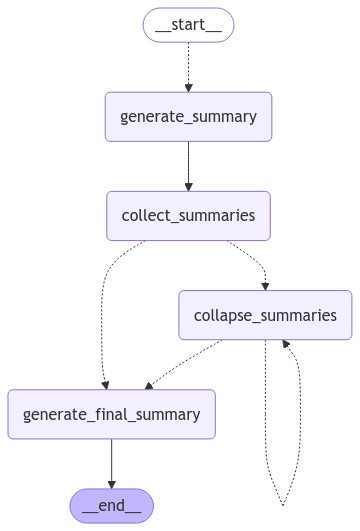

In [84]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

In [85]:
async for step in app.astream(
    {"contents": [doc.page_content for doc in split_docs]},
    {"recursion_limit": 10},
):
    print(list(step.keys()))

['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['collect_summaries']
['collapse_summaries']
['collapse_summaries']
['generate_final_summary']


In [86]:
print(step)

{'generate_final_summary': {'final_summary': "Here's a consolidated summary of the main themes in bullet points:\n\n* **Importance of Continuous Learning and Professional Development:**\n + Continuous learning is essential for career growth and achieving dreams.\n + Stepping out of one's comfort zone is where the magic happens.\n + Investing time and effort into developing new skills can lead to significant career growth and innovation.\n + Completing courses and certifications can equip individuals with valuable skills and knowledge.\n + Hands-on training and practical experience are crucial for mastering new technologies.\n + Staying up-to-date with the latest trends and technologies is essential for success in the field of AI and Machine Learning.\n* **Value of IBM Machine Learning Specialist Advanced Certification:**\n + The certification demonstrates expertise in machine learning and advanced concepts.\n + It equips individuals with skills in using various machine learning algorit

In [94]:
print(step["generate_final_summary"])

{'final_summary': "Here's a consolidated summary of the main themes in bullet points:\n\n* **Importance of Continuous Learning and Professional Development:**\n + Continuous learning and professional development are essential in the fields of machine learning, data science, and AI.\n + It's crucial to stay at the forefront of advancements and continuously learn and grow.\n + Investing in professional development and staying up-to-date with the latest trends and technologies is valuable.\n* **Value of Certifications and Badges:**\n + Certifications and badges demonstrate expertise and readiness for new challenges.\n + They showcase skills and knowledge in machine learning, data science, and AI.\n + Achieving certifications and badges requires dedication and a deep understanding of key concepts.\n* **Key Skills and Knowledge:**\n + Key skills include data science, machine learning, deep learning, cloud computing, and AI.\n + Proficiency in tools and platforms such as IBM, AWS, Oracle, an